# Skin Cancer Detection with VGG16

This notebook demonstrates how to classify skin cancer images as benign or malignant, by performing transfer learning on the pre-trained VGG16 deep learning model.

To get started, you must have the following requirements installed:

1. `tensorflow` - to preprocess data and work with the VGG16 model
2. `numpy` - to prepare data during testing
3. `matplotlib` - to display images in the Jupyter notebook
4. `notebook` - to run this notebook in a Jupyter server

It is recommended to have a virtual environment to isolate these requirements from the rest of your system. This can be done using Python's virtualenv package.

First, open a Terminal (Command Prompt on Windows) in the same folder as this notebook and create a virtual environment:

```shell
python3 -m venv env
```

Next, activate the virtual environment. For Windows users:

```shell
.\env\Scripts\activate
```

For Linux and MacOS users:

```shell
source env/bin/activate
```

Now you can safely install the above requirements in your virtual environment:

```shell
pip install tensorflow numpy matplotlib notebook
```

After installation is complete, launch the Jupyter server to edit this notebook:

```shell
jupyter notebook
```

## Getting Started

The following imports are necessary to work with this notebook:

In [2]:
# General imports
import os
import numpy as np
from glob import glob
from datetime import datetime

# Image processing and manipulation imports
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image as _Imgdis

# Tensorflow and Keras imports
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

Please refer to the <a href="https://github.com/ravi-aratchige/IPCV/blob/main/5.%20Pneumonia%20Detection/Pneumonia%20Detection%20with%20VGG16.ipynb">Jupyter notebook on pneumonia detection</a> for a refresher on transfer learning and the VGG16 model.

## The Dataset

We will be working with an open-source dataset of cancerous skin moles (ඉන්නෝ) photographs published by Claudio Fanconi. The dataset can be downloaded <a href="https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign">here</a>.

This dataset has two classes of images:

1. `benign`
2. `malignant`

### Exploratory Data Analysis

First, we'll inspect the data to see what we're working with.

In [12]:
!tree "./data" -d

./data
├── test
│   ├── benign
│   └── malignant
└── train
    ├── benign
    └── malignant

6 directories


As shown above, the dataset has been divided into 3 sub-directories:

1. `test` - testing data
2. `train` - training data

We can also inspect how many images belong to each class in the training and testing data.

In [13]:
def count_images(directory):
    return sum(
        1 for _ in os.listdir(directory) if _.endswith((".png", ".jpg", ".jpeg"))
    )


def summarize_data(base_dir):
    return {
        split: {
            category: count_images(os.path.join(base_dir, split, category))
            for category in ["benign", "malignant"]
        }
        for split in ["train", "test"]
    }


base_dir = "./data"
data_summary = summarize_data(base_dir)

for split, categories in data_summary.items():
    print(f"{split.capitalize()} data:")
    for category, count in categories.items():
        print(f"  {category}: {count} images")
    print()

Train data:
  benign: 1440 images
  malignant: 1197 images

Test data:
  benign: 360 images
  malignant: 300 images



Let's load the data from the disk to see what we're working with.

In [9]:
# Set paths for directories containing training and testing data
training_img_path = "data/train"
testing_img_path = "data/test"

We can view how many image files are available in a specific directory using the `os` module and list comprehension.

In [11]:
# Set the benign image folder path from the training data
benign_img_path = training_img_path + "/benign"

# Perform list comprehension to get filenames of all benign images (in training data)
benign_img_filenames = [
    f for f in os.listdir(benign_img_path) if os.path.isfile(os.path.join(benign_img_path, f))
]

print(f"Found {len(benign_img_filenames)} benign images in the training dataset.\n")

Found 1440 benign images in the training dataset.



Now, we can use these filenames to display a few images from the respective directory.

Example images: 

1283.jpg


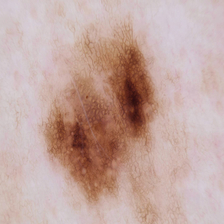

319.jpg


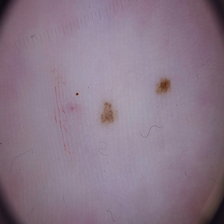

500.jpg


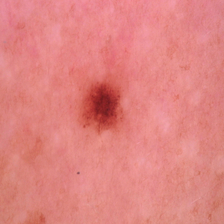

1626.jpg


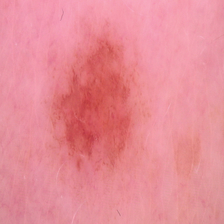

366.jpg


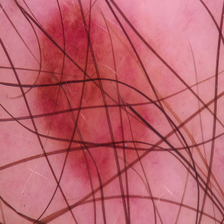

In [8]:
print("Example images: \n")

# Loop through first 5 images
for i in range(5):
    # Print the image's filename
    print(benign_img_filenames[i])

    # Display the image using `IPython` module
    display(
        _Imgdis(
            filename=benign_img_path + "/" + benign_img_filenames[i],
            width=240,
            height=240,
        )
    )

These are all images of benign skin cancer moles taken from the training dataset.

### Data Augmentation

As done previously in the <a href="https://github.com/ravi-aratchige/IPCV/blob/main/5.%20Pneumonia%20Detection/Pneumonia%20Detection%20with%20VGG16.ipynb">pneumonia detection Jupyter notebook</a>, we must augment the image dataset that we have, to ensure that the limited amount of data we have does not cause the model to overfit during training.

For this, we use the `ImageDataGenerator` class from Keras.

In [14]:
# Instantiate data generator for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Instantiate data generator for testing data
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

After this, we can load the images using the `flow_from_directory()` method in the data generators created above.

In [15]:
# Load the training data via the training data generator
training_set = train_datagen.flow_from_directory(
    directory=training_img_path,    # The folder which contains subfolders containing the training data.
    target_size=(224, 224),         # The size of the input images. Every image will be resized to this size.
    batch_size=32,                  # Number of images to be yielded by the generator per batch
    class_mode="categorical",       # The type of label arrays returned
)

# Load the testing data via the training data generator
testing_set = train_datagen.flow_from_directory(
    directory=testing_img_path,     # The folder which contains subfolders containing the training data.
    target_size=(224, 224),         # The size of the input images. Every image will be resized to this size.
    batch_size=32,                  # Number of images to be yielded by the generator per batch
    class_mode="categorical",       # The type of label arrays returned
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


When training the model, we can use `glob` to retrieve the paths of the directories containing the training data, separated as classes.

In [19]:
# Load sub-folders containing training data
folders = glob("./data/train/*")
print(folders)

['./data/train/malignant', './data/train/benign']


## The Model

We will be using the pre-trained VGG16 model from `keras.applications` for this scenario, by utilizing transfer learning.

First, we load the model (pre-trained on a popular dataset, in this case, the **ImageNet** dataset), while excluding the final pre-trained dense layer, since we want to add a custom dense layer at the end, which we will be training and fine-tuning for our scenario.

In [16]:
# Load the VGG16 model

vgg = VGG16(
    input_shape=(224, 224, 3),  # Specify input image properties, i.e. 224px by 224px, 3 color channel (RGB)
    weights="imagenet",         # Load the pre-trained weights of the ImageNet dataset
    include_top=False,          # Exclude the final dense layer
)

We also freeze the pre-trained layers of the model to ensure that their weights aren't updated during training, which is a key aspect of transfer learning.

In [17]:
# Freeze layers of model
for layer in vgg.layers:
    layer.trainable = False

Any new layers added by us, however, will not be frozen.

Before we connect any new dense layers to be trainined on the image classification task, we need to add a **Flatten** layer. It reshapes the output of the preceding layer into a one-dimensional vector, which dense layers can work on. Flatten layers do not contain any weights, and are not changed during training.

It acts as a bridge between convolution/pooling layers (which work with 3D tensors) and dense layers.

In [18]:
# Instantiate flatten layer
flatten_layer = Flatten()

# Add flatten layer after VGG16's current output layer (final convolutional/pooling layer)
x = (flatten_layer)(vgg.output)

Next, we can add a dense layer after the flatten layer to provide the output (prediction) made by the model.

This layer is trainable, and learns from the skin cancer dataset during training.

In [20]:
# Instantiate dense layer
dense_layer = Dense(
    units=len(folders),     # The dimensionality of the output space (in this case, 2)
    activation="softmax",   # The activation function of the neurons in the layer
)

# Add dense layer after flatten layer to get model output
prediction = (dense_layer)(x)

Finally, we can combine the pre-trained layers of the VGG16 model with the flatten and dense layers we created. This produces the final model which can be trained for our specific scenario.

In [21]:
# Instantiate model with VGG16's pre-trained layers and the custom flattened and dense layers
model = Model(
    inputs=vgg.input,
    outputs=prediction,
)

# View the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Here, we can notice our custom flatten and dense layers connected with the frozen layers of the VGG16 model.

Finally, we configure the model for training, i.e. compile the model by specifying the optimizer and loss function to be used, as well as the metrics required to be measured.

In [22]:
# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)